In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import fetchRaw as FR
import preprocess as PP
import insertToDB as ID
import statistics as st
import math

# Fetch Raw from Source

In [2]:
 data_noduplicate = FR.fetchRaw(savename='campaign_dataset_noduplicate.json',save=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.41it/s]


# Preprocess (remove duplicate, transform dtype, extract more details)

In [3]:
data = PP.preprocess(data_noduplicate,load_from_local='')

# Insert Clean Data to Database (PostgreSQL)

In [4]:
ID.insertToDB(data,usr='yugachang',pwd='yuga',db='campaigndb',host='127.0.0.1',port='5432')

# Analysis 

In [5]:
# read dataframe from source
df = pd.json_normalize(data)
df.fillna(value=np.nan, inplace=True)

In [6]:
# Transformation for analysis
def selectNum(x):
    if isinstance(x,list):
        if len(x) > 1:
            mean = st.mean(x)
            dev = st.stdev(x)
            new_num = []
            threshold = 1
            for num in x:
                if (num >= (mean-threshold*dev)) and (num <= (mean+threshold*dev)):
                    new_num.append(num)
            return int(st.mean(new_num))
        else:
            return int(x[0])
    return x

def checkSupportUnit(x):
    if isinstance(x,list):
        new_support = []
        for s in x:
            if '、' in s:
                new_support += s.split('、')
            else:
                new_support.append(s)
        return " ".join(sorted(new_support)).replace('台','臺')
    return x
    
# add new columns of mean price
df['meanprice'] = df['price'].apply(selectNum)

# add new columns of mean price
df['supportUnit'] = df['supportUnit'].apply(checkSupportUnit)

In [71]:
# Check Frequency
# count of city
print(df[df.city.notna()].groupby('city').size().shape,df[df.city.notna()].groupby('city').size().sort_values(ascending=False))
print('-----------------------------------')

# count of category
print(df[df.category.notna()].groupby('category').size().shape,df[df.category.notna()].groupby('category').size().sort_values(ascending=False))
print('-----------------------------------')

# count of isOnline
print(df[df.isOnline.notna()].groupby('isOnline').size().shape,df[df.isOnline.notna()].groupby('isOnline').size().sort_values(ascending=False))
print('-----------------------------------')

# count of showUnit
print(df[df.showUnit.notna()].groupby('showUnit').size().shape,df[df.showUnit.notna()].groupby('showUnit').size().sort_values(ascending=False))
print('-----------------------------------')

# count of supportUnit
print(df[df.supportUnit.notna()].groupby('supportUnit').size().shape,df[df.supportUnit.notna()].groupby('supportUnit').size().sort_values(ascending=False))
print('-----------------------------------')

# count of sourceWebName
print(df[df.sourceWebName.notna()].groupby('sourceWebName').size().shape,df[df.sourceWebName.notna()].groupby('sourceWebName').size().sort_values(ascending=False))
print('-----------------------------------')

# count of title over amount of number (同一個活動舉辦複數場次)
amount = 2
event = df.groupby('title').size().sort_values(ascending=False)
print(event[event > amount].shape, event[event > amount])

(24,) city
臺北市    675
新北市    620
臺中市    423
臺南市    413
高雄市    407
桃園市    260
彰化縣    212
南投縣    173
苗栗縣     90
屏東縣     74
新竹縣     50
宜蘭縣     36
澎湖縣     27
花蓮縣     24
雲林縣     24
基隆市     22
新竹市     20
嘉義縣     14
臺東縣      7
連江縣      5
金門縣      5
嘉義市      3
花蓮市      2
屏東市      1
dtype: int64
-----------------------------------
(15,) category
6     1912
7      401
19     349
1      310
8      190
2      143
15     105
3       66
16      62
17      58
13      31
11      28
4       28
5       20
14       3
dtype: int64
-----------------------------------
(2,) isOnline
False    3682
True       24
dtype: int64
-----------------------------------
(1642,) showUnit
(不分國籍)本活動無實體展演者                                                110
(中華民國)彰化縣文化局                                                    81
(中華民國)臺北市立圖書館                                                   60
(中華民國)新北市立圖書館志工                                                 49
(中華民國)本活動無實體展演者                                                 32
    

In [13]:
tmp = {}
for row in df.groupby('city').size().index:
    tmp[row] = {}
    for col in df.groupby('category').size().index:
        tmp[row][col] = 0
count = 0
check = df.groupby(['city','category']).size()
for row, col in df.groupby(['city','category']).size().index:
    tmp[row][col] = check[count]
    count+=1

In [62]:
tmp = pd.DataFrame(tmp)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tmp)

    南投縣  嘉義市  嘉義縣  基隆市  宜蘭縣  屏東市  屏東縣  彰化縣  新北市  新竹市  ...  臺北市  臺南市  臺東縣  花蓮市  \
1    17    0    1    1    0    0    8    3   21    5  ...   83   34    1    0   
11    9    0    0    0    0    0    0    0    2    0  ...    3    1    0    0   
13    0    0    0    2    0    0    1    5    1    0  ...    5    8    0    0   
14    0    0    0    0    0    0    0    0    2    0  ...    0    0    0    0   
15    3    0    0    0    0    0    0    2    6    0  ...   26    1    0    0   
16    7    0    0    0    1    0    1    0    5    0  ...    5    7    0    0   
17    0    0    0    0    1    0    0    0    2    0  ...   30    1    0    0   
19    7    0    1    0    0    0    3   35   18    0  ...  164   42    0    0   
2    12    1    3    0    1    0    6    5    3    5  ...   58    5    0    0   
3     9    0    1    0    0    1   12    3    3    0  ...   15    1    2    0   
4     0    0    3    0    1    0    1    1    3    1  ...   12    1    0    0   
5     0    0    0    0    0 

<AxesSubplot:>

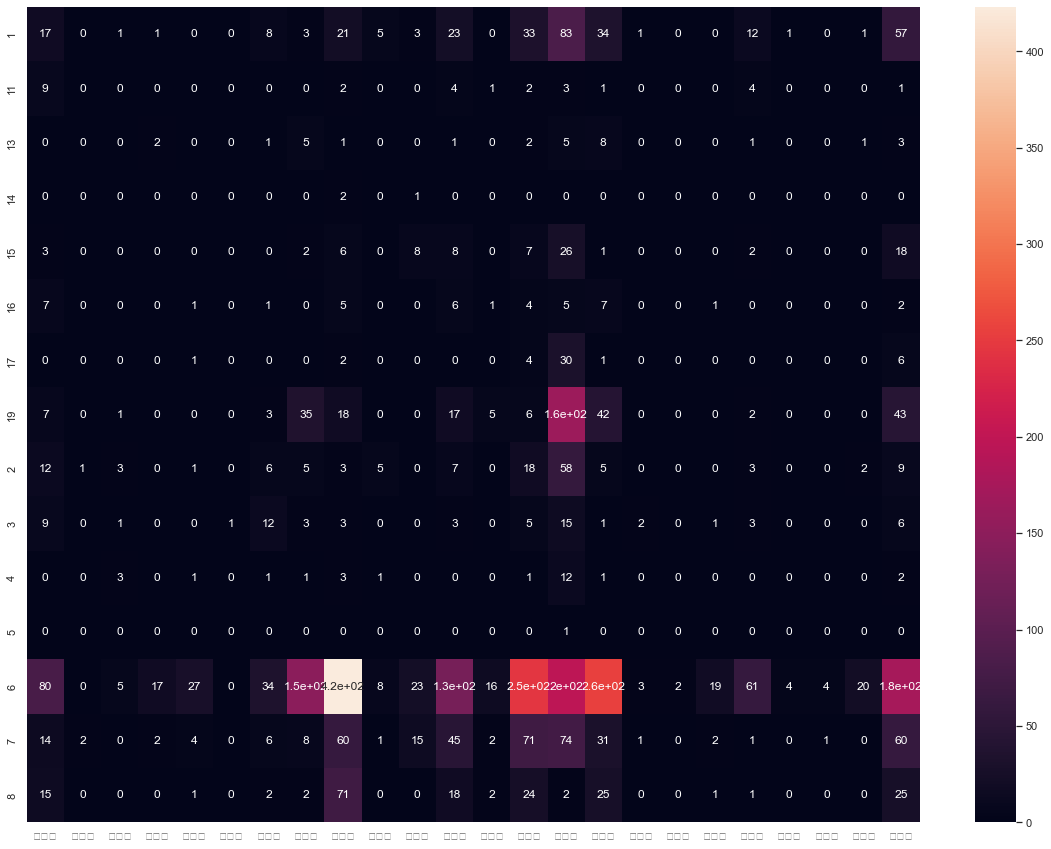

In [47]:
# Check frequency according to city and category
import seaborn as sns
# %matplotlib inline
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(tmp, annot=True)

/Users/yugachang/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yugachang/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yugachang/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yugachang/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yugachang/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7

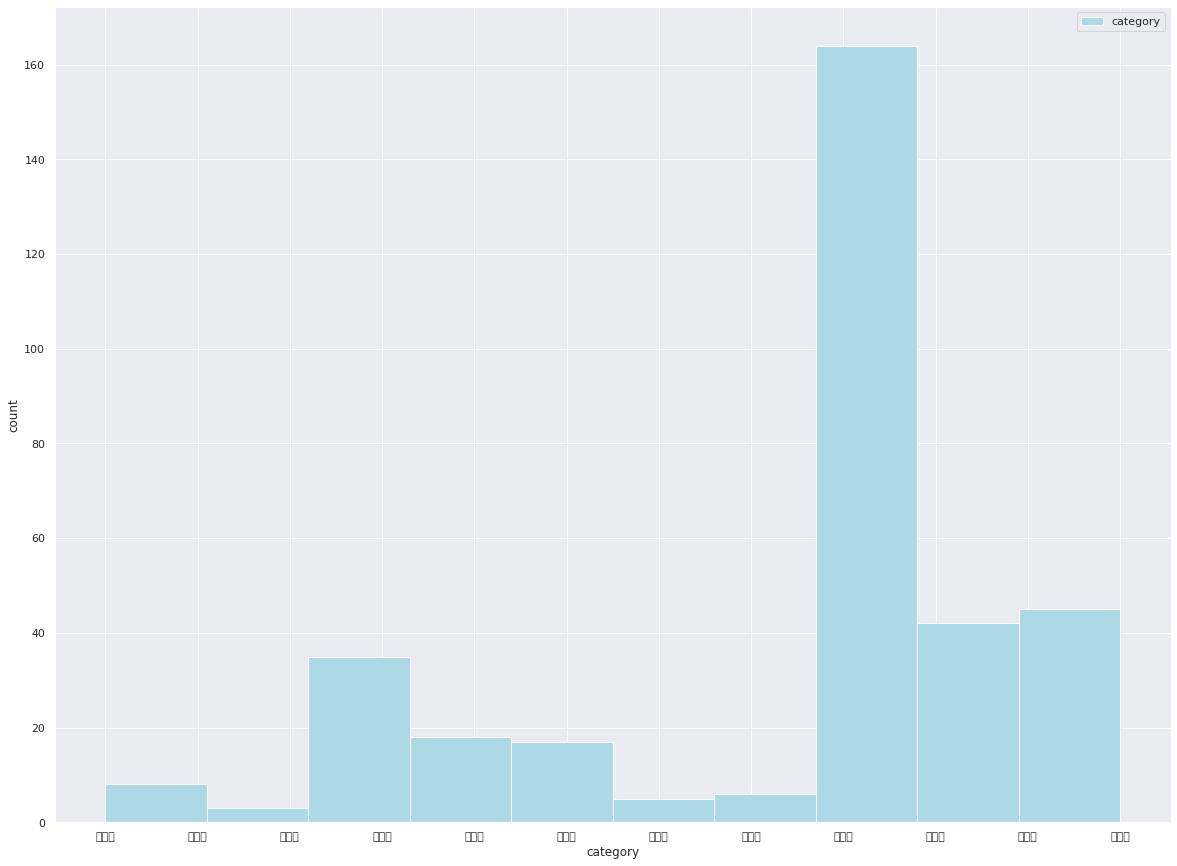

In [58]:
# For example: check 研習課程(category=19)
order = list(tmp.T.index)
course = []
count = 0
for row in tmp.T['19']:
    course += [order[count]]*row
    count+=1

plt.hist(course, density=False, color = 'lightblue', cumulative = False, label = "category")
plt.legend()
plt.xlabel('category')
plt.ylabel('count')
plt.show()